<a href="https://colab.research.google.com/github/loiswoo/Time-Series/blob/main/TS_study_w3(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S&P 500 Stocks Prediction using ARIMA


https://www.kaggle.com/code/yassinesfaihi/arima-time-series-forecasting-s-p-500-stock/notebook

참고한 자료들: 3주차  baseline, 
삼성 주가 예측 코드


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import r2_score

In [2]:
!pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.1 MB/s eta 0:00:00


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [6]:
df = pd.read_csv("/content/all_stocks_5yr.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.00,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.00,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.00,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.00,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.00,MMM


In [ ]:
df.info() #날짜, 시가, 고가, 저가, 종가, 거래량 , 종류 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606801 entries, 0 to 606800
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    606801 non-null  object 
 1   Open    606417 non-null  float64
 2   High    606593 non-null  float64
 3   Low     606574 non-null  float64
 4   Close   606801 non-null  float64
 5   Volume  606395 non-null  float64
 6   Name    606801 non-null  object 
dtypes: float64(5), object(2)
memory usage: 32.4+ MB


In [ ]:
df['Name'].value_counts() #총 88개의 종류 

MMM     1258
MCHP    1258
MGM     1258
MTD     1258
MET     1258
        ... 
EVHC     174
FTI      145
DXC      102
BHGE      28
BHF       20
Name: Name, Length: 503, dtype: int64

In [7]:
df = df[df['Name'] == 'MMM'] #NAME = MM인 종목만 사용
                              #1258개의 dataset

In [8]:
df = df[500:] #최근 데이터만 반영하기 위하여 dataset 줄임

In [ ]:
df.shape #758개의 데이터셋 사용

(758, 7)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
500,2014-08-11,140.93,141.50,140.54,140.58,1919082.00,MMM
501,2014-08-12,140.62,141.21,140.43,140.88,2176055.00,MMM
502,2014-08-13,141.35,141.83,140.92,141.80,3104251.00,MMM
503,2014-08-14,142.00,142.39,141.85,142.34,1586871.00,MMM
504,2014-08-15,142.81,142.98,141.02,141.92,1960967.00,MMM


In [ ]:
df.isnull().sum() #Close(종가)만 사용할 것이기 때문에 결측치 제거 x 

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 500 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    758 non-null    object 
 1   Open    757 non-null    float64
 2   High    758 non-null    float64
 3   Low     757 non-null    float64
 4   Close   758 non-null    float64
 5   Volume  758 non-null    float64
 6   Name    758 non-null    object 
dtypes: float64(5), object(2)
memory usage: 47.4+ KB


In [9]:
#Date의 자료형을 object → datetime
df['Date'] = pd.to_datetime(df.Date)

df = df.set_index(df.Date)
df.drop('Date', axis = 1, inplace = True)

## 1. Check for Stationarity of Time Series

In [10]:
ts = df['Close']
ts.head()

Date
2014-08-11   140.58
2014-08-12   140.88
2014-08-13   141.80
2014-08-14   142.34
2014-08-15   141.92
Name: Close, dtype: float64

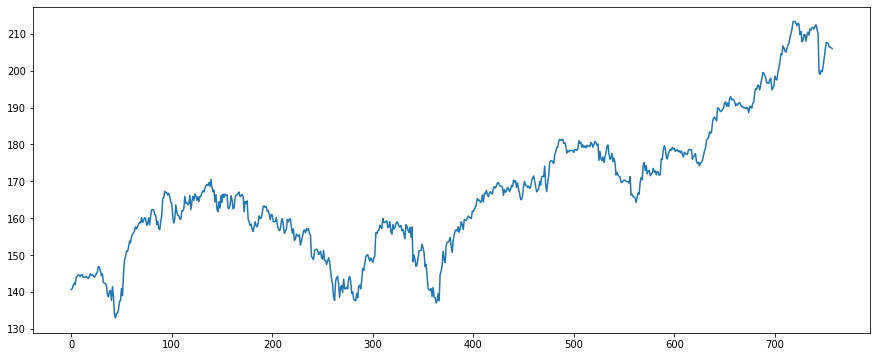

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(range(len(ts)), ts)

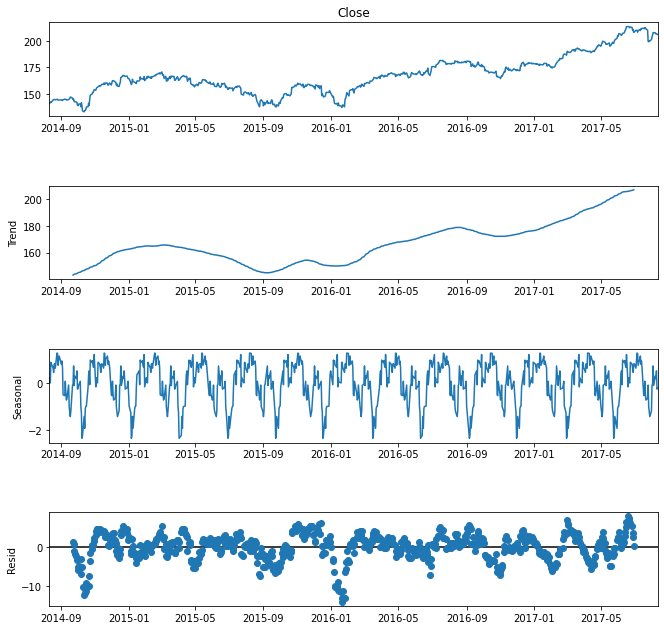

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model = 'additive', period = 60) #period를 2개월로 잡음. 
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

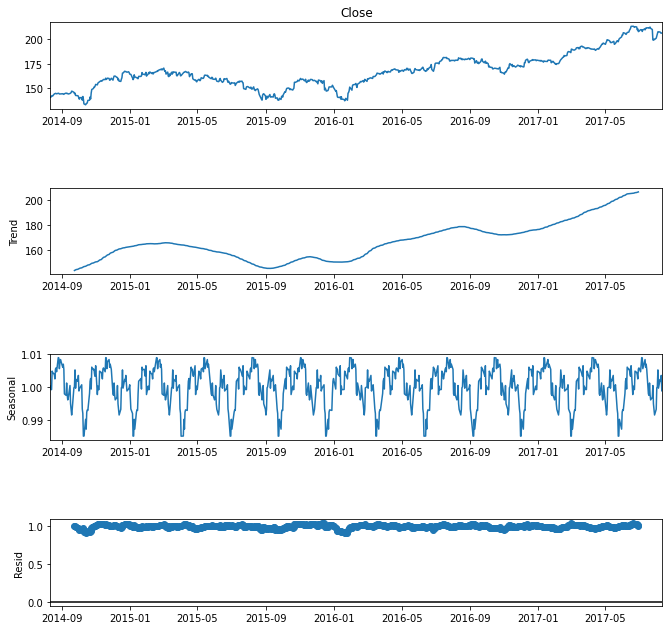

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model = 'multiplicative', period = 60) #model = muliplicative #residual이 거의 나타나지 않음 
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [12]:
#train:test = 8:2
#test: 152
df_train = df[:606] #2014-08-11~2017-01-04
df_test = df[606:] #2017-01-05~2017-08-11

In [ ]:
df_train['Close'].describe()

count   606.00
mean    160.46
std      11.84
min     132.90
25%     151.48
50%     160.60
75%     168.68
max     181.42
Name: Close, dtype: float64

In [ ]:
df_train

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2014-08-11,140.93,141.50,140.54,140.58,1919082.00,MMM
2014-08-12,140.62,141.21,140.43,140.88,2176055.00,MMM
2014-08-13,141.35,141.83,140.92,141.80,3104251.00,MMM
2014-08-14,142.00,142.39,141.85,142.34,1586871.00,MMM
2014-08-15,142.81,142.98,141.02,141.92,1960967.00,MMM
...,...,...,...,...,...,...
2016-12-28,178.88,179.45,178.02,178.08,1287918.00,MMM
2016-12-29,178.29,179.14,178.03,178.41,1101983.00,MMM
2016-12-30,179.00,179.48,178.28,178.57,1594248.00,MMM


In [ ]:
df_test

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-01-05,178.26,179.14,176.89,177.71,1447848.00,MMM
2017-01-06,177.29,178.60,175.80,178.23,1625049.00,MMM
2017-01-09,178.37,178.38,177.20,177.27,1622625.00,MMM
2017-01-10,177.36,177.49,176.31,176.58,2030149.00,MMM
2017-01-11,176.63,178.45,176.39,177.89,1579593.00,MMM
...,...,...,...,...,...,...
2017-08-07,207.90,208.40,206.68,207.44,1172563.00,MMM
2017-08-08,206.83,207.89,205.69,206.43,1856282.00,MMM
2017-08-09,206.69,207.91,205.59,206.48,1622213.00,MMM


<Axes: ylabel='Density'>

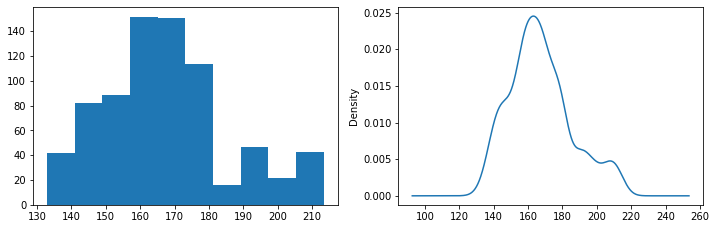

In [ ]:
plt.figure(figsize =(12,8))
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')

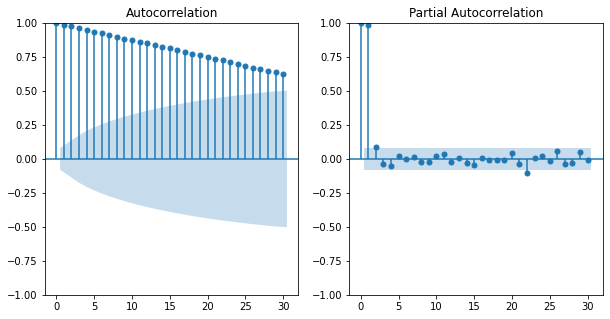

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(df_train.Close.values.squeeze(), lags = 30, ax=ax[0] );
sm.graphics.tsa.plot_pacf(df_train.Close.values.squeeze(), lags = 30, ax = ax[1]);

Autocorrelation에서 서서히 감소하고 있기 때문에 Non-stationary한 데이터라고 볼 수 있다. 따라서 Differencing(차분) 과정을 거칠 필요가 있다.

## 2. Make the Series Staionary

In [13]:
#Differencing

diff_df_train = df_train.copy()
diff_df_train = diff_df_train['Close'].diff()
diff_df_train = diff_df_train.dropna()
print('###### Raw Data #####')
print(df_train['Close'])
print('###### Differenced Data ####')
print(diff_df_train)

###### Raw Data #####
Date
2014-08-11   140.58
2014-08-12   140.88
2014-08-13   141.80
2014-08-14   142.34
2014-08-15   141.92
              ...  
2016-12-28   178.08
2016-12-29   178.41
2016-12-30   178.57
2017-01-03   178.05
2017-01-04   178.32
Name: Close, Length: 606, dtype: float64
###### Differenced Data ####
Date
2014-08-12    0.30
2014-08-13    0.92
2014-08-14    0.54
2014-08-15   -0.42
2014-08-18    2.20
              ... 
2016-12-28   -0.84
2016-12-29    0.33
2016-12-30    0.16
2017-01-03   -0.52
2017-01-04    0.27
Name: Close, Length: 605, dtype: float64


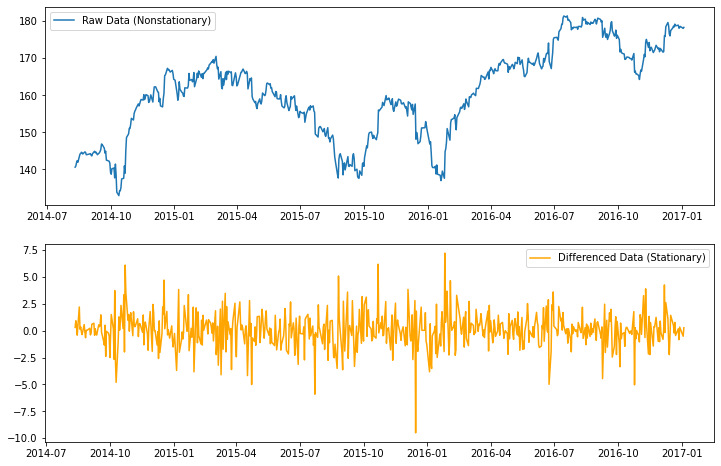

In [ ]:
plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(df_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_df_train, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

1차 차분한 데이터는 0에 더 가깝게 형성된 것을 볼 수 있다

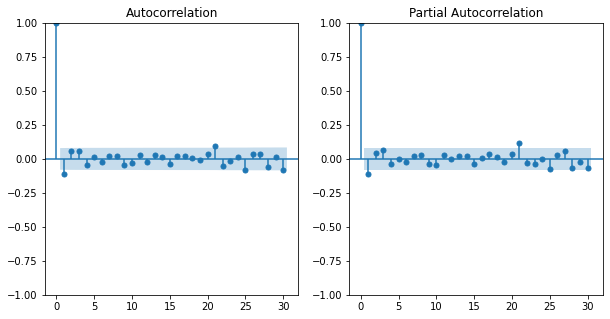

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sm.graphics.tsa.plot_acf(diff_df_train.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_df_train.values.squeeze(), lags = 30, ax = ax[1]); #그래프 한번만 출력하기 위해서 ; 추가

1차 차분을 통해 확인한 결과, Autocorrelation이 lag2일때 급격하게 낮아지고 있고, 특정한 패턴을 보이지 않기 때문에 Stationary한 데이터라고 볼 수 있다

## 3. Forecasting a Time Series to Test Set

### ARIMA

In [ ]:
#ARIMA model
model = ARIMA(df_train['Close'], order = (1,1,0))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  606
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1155.711
Date:                Mon, 27 Mar 2023   AIC                           2315.423
Time:                        10:53:48   BIC                           2324.233
Sample:                             0   HQIC                          2318.851
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1114      0.037     -3.028      0.002      -0.184      -0.039
sigma2         2.6715      0.099     26.865      0.000       2.477       2.866
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               245.34
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-value 값이 충분히 작은 것으로 보아 괜찮은 모델로 보이나, AIC가 너무 커서 좀 더 나은 hyperparameter 탐색

In [ ]:
import itertools
p = range(0,3) #p:0~2
d = range(1,2) #d:1
q = range(0,3) #q:0~2
pdq = list(itertools.product(p,d,q))
aic = []
for i in pdq:
  try:
    model = ARIMA(df_train['Close'], order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
  except:
    pass

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr

ARIMA: (0, 1, 0) >> AIC: 2321.0
ARIMA: (0, 1, 1) >> AIC: 2316.22
ARIMA: (0, 1, 2) >> AIC: 2314.94
ARIMA: (1, 1, 0) >> AIC: 2315.42


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr

ARIMA: (1, 1, 1) >> AIC: 2316.86


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (1, 1, 2) >> AIC: 2316.28
ARIMA: (2, 1, 0) >> AIC: 2316.08


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr

ARIMA: (2, 1, 1) >> AIC: 2316.98


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (2, 1, 2) >> AIC: 2311.18


(p,d,q) = (2,1,2)일 때 AIC 2311.18로 가장 좋은 성능이 나왔다

In [ ]:
optimal = [(pdq[i], j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 2311.18)]

In [ ]:
model_opt = ARIMA(df_train['Close'], order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  606
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1150.588
Date:                Mon, 27 Mar 2023   AIC                           2311.177
Time:                        10:57:16   BIC                           2333.203
Sample:                             0   HQIC                          2319.748
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4326      0.035     12.255      0.000       0.363       0.502
ar.L2         -0.9043      0.033    -27.552      0.000      -0.969      -0.840
ma.L1         -0.4713      0.020    -23.171      0.000      -0.511      -0.431
ma.L2          0.9773      0.022     45.309      0.000       0.935       1.020
sigma2         2.6220      0.095     27.473      0.000       2.435       2.809
===================================================================================
Ljung-Box (L1) (Q):                   3.65   Jarque-Bera (JB):               291.67
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast = model_opt_fit.forecast(152) #df_test의 152개 관측치 예측

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
list(forecast)

[178.51428778796068,
 178.02699150908953,
 177.64049787476554,
 177.91398019627644,
 178.3817977007744,
 178.33685095266554,
 177.89435074641747,
 177.74357980921863,
 178.07852128930557,
 178.35975592798366,
 178.17851816821508,
 177.84579181329792,
 177.86575776177338,
 178.17528601219163,
 178.29112645389483,
 178.06132400610673,
 177.85715889641043,
 177.9766560636639,
 178.2129790295224,
 178.20714410035504,
 177.99090825009014,
 177.9026453608287,
 178.06001107928455,
 178.2079024766815,
 178.12956840638608,
 177.96194130510082,
 177.9602681211406,
 178.11113300547154,
 178.17790739465215,
 178.070362481007,
 177.9634551183032,
 178.01446411708235,
 178.13320819501976,
 178.13844613825407,
 178.033329235443,
 177.9831208714691,
 178.05646108351712,
 178.13359113862356,
 178.1006330626994,
 178.01662571063383,
 178.0100903929379,
 178.08323293285088,
 178.12078303517916,
 178.07088217967504,
 178.015338675792,
 178.03643798795153,
 178.09579429623855,
 178.10239016544045,
 178.051

In [ ]:
fcast = list(forecast)

In [ ]:
print(f"MSE : {mean_squared_error(df_test['Close'], fcast)}")
print(f"RMSE : {np.sqrt(mean_squared_error(df_test['Close'],fcast))}")
print(f"MAE : {mean_absolute_error(df_test['Close'],fcast)}")
print(f"MAPE : {mean_absolute_percentage_error(df_test['Close'],fcast)}")
print(f"R2 : {r2_score(df_test['Close'], fcast)}")

MSE : 421.18763916936854
RMSE : 20.52285650608532
MAE : 17.32073341751599
MAPE : 0.08577818693707967
R2 : -2.1055549636906314


### SARIMA

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [16]:
# Parameter search 
import itertools
print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic=[]
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(df_train['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))  
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 2706.55
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 2317.02
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 2318.45
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 2528.23
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 2318.45
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 2320.07
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 2446.59
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 2320.45
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 2319.85
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 2698.28
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 2314.19
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 2315.87
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 2525.94
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 2315.88
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 2316.85
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 2446.17
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 2317.85
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 2317.06
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 2695.26
SARIMA: (0, 1, 2)(0, 1, 1, 12) 

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(2, 1, 2, 12) >> AIC : 2318.22
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : 2697.87
SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : 2314.65
SARIMA: (2, 1, 0)(0, 1, 2, 12) >> AIC : 2316.36
SARIMA: (2, 1, 0)(1, 1, 0, 12) >> AIC : 2525.49
SARIMA: (2, 1, 0)(1, 1, 1, 12) >> AIC : 2316.36
SARIMA: (2, 1, 0)(1, 1, 2, 12) >> AIC : 2317.36
SARIMA: (2, 1, 0)(2, 1, 0, 12) >> AIC : 2446.98
SARIMA: (2, 1, 0)(2, 1, 1, 12) >> AIC : 2318.35
SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : 2317.66
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : 2697.93
SARIMA: (2, 1, 1)(0, 1, 1, 12) >> AIC : 2315.73
SARIMA: (2, 1, 1)(0, 1, 2, 12) >> AIC : 2317.48
SARIMA: (2, 1, 1)(1, 1, 0, 12) >> AIC : 2527.22
SARIMA: (2, 1, 1)(1, 1, 1, 12) >> AIC : 2317.48
SARIMA: (2, 1, 1)(1, 1, 2, 12) >> AIC : 2318.43
SARIMA: (2, 1, 1)(2, 1, 0, 12) >> AIC : 2448.51
SARIMA: (2, 1, 1)(2, 1, 1, 12) >> AIC : 2319.46


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(2, 1, 2, 12) >> AIC : 2318.77
SARIMA: (2, 1, 2)(0, 1, 0, 12) >> AIC : 2649.65
SARIMA: (2, 1, 2)(0, 1, 1, 12) >> AIC : 2307.89
SARIMA: (2, 1, 2)(0, 1, 2, 12) >> AIC : 2307.86


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(1, 1, 0, 12) >> AIC : 2507.82


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(1, 1, 1, 12) >> AIC : 2308.05


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(1, 1, 2, 12) >> AIC : 2311.24


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 0, 12) >> AIC : 2442.32


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 1, 12) >> AIC : 2309.75


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 2, 12) >> AIC : 2310.05


In [17]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((2, 1, 2), (0, 1, 2, 12)), 2307.86)]

In [18]:
model_opt = SARIMAX(df_train['Close'].values, order=optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  606
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -1146.932
Date:                            Mon, 27 Mar 2023   AIC                           2307.864
Time:                                    16:05:34   BIC                           2338.560
Sample:                                         0   HQIC                          2319.819
                                            - 606                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4318      0.034     12.660      0.000       0.365       0.499
ar.L2         -0.9019      0.034    -26.891      0.000      -0.968      -0.836
ma.L1         -0.4709      0.019    -24.352      0.000      -0.509      -0.433
ma.L2          0.9788      0.021     45.669      0.000       0.937       1.021
ma.S.L12      -1.0597     12.390     -0.086      0.932     -25.344      23.225
ma.S.L24       0.0598      0.724      0.083      0.934      -1.359       1.479
sigma2         2.5810     32.001      0.081      0.936     -60.141      65.303
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):               247.54
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.22
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
forecast = model_opt_fit.forecast(152) #df_test의 152개 관측치 예측

In [20]:
list(forecast)

[177.96205295889274,
 177.71707064564814,
 177.36292785514703,
 177.48858880575872,
 178.40073889321383,
 178.1829325333293,
 177.69088757945278,
 177.85687534810907,
 178.31577781574092,
 178.82904584278916,
 178.32956302785695,
 178.47118476424308,
 178.01972639828512,
 178.63843339518627,
 178.85397906677227,
 178.45423828915415,
 178.66874173964962,
 178.60938021872244,
 178.84270310248598,
 179.1161004362064,
 179.01747765804393,
 179.12759001692996,
 178.95579639201026,
 179.58864371825842,
 179.05674393198453,
 179.14890800824628,
 179.20965944823868,
 179.21797046244765,
 179.74826560989814,
 179.4572323964579,
 179.30571579539728,
 179.62189576360856,
 179.88883026550744,
 180.11819282350837,
 179.66819293828965,
 180.07336863788373,
 179.6940807618911,
 180.05747376779473,
 180.0976929407344,
 179.85251854513913,
 180.29188494811345,
 180.19020911737263,
 180.2024591002991,
 180.41856748519126,
 180.49459394588882,
 180.73178280083408,
 180.45734122638933,
 180.93125875909624

In [21]:
fcast = list(forecast)

In [22]:
print(f"MSE : {mean_squared_error(df_test['Close'], fcast)}")
print(f"RMSE : {np.sqrt(mean_squared_error(df_test['Close'],fcast))}")
print(f"MAE : {mean_absolute_error(df_test['Close'],fcast)}")
print(f"MAPE : {mean_absolute_percentage_error(df_test['Close'],fcast)}")
print(f"R2 : {r2_score(df_test['Close'], fcast)}")

MSE : 244.19480472339097
RMSE : 15.626733654970606
MAE : 13.166386302114658
MAPE : 0.0652312409949085
R2 : -0.8005285943618075


동일한 Test Set에 대해 예측해본 결과, SARIMA의 성능이 ARIMA보다 좋은 것을 알 수 있다. 

## 4. Forecasting a Time Series to Future

Text(0.5, 1.0, 'Train and Test Data')

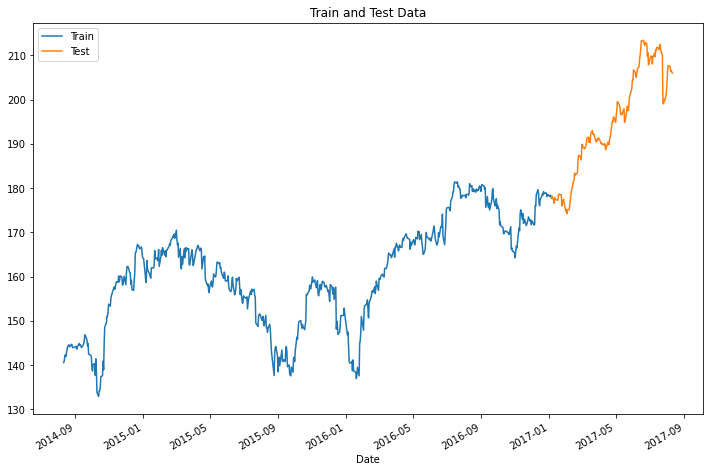

In [ ]:
df_train['Close'].plot(legend = True, label ='Train')
df_test['Close'].plot(legend = True, label = 'Test', figsize = (12, 8))
plt.title('Train and Test Data')

Text(0.5, 1.0, 'Train and Test Data')

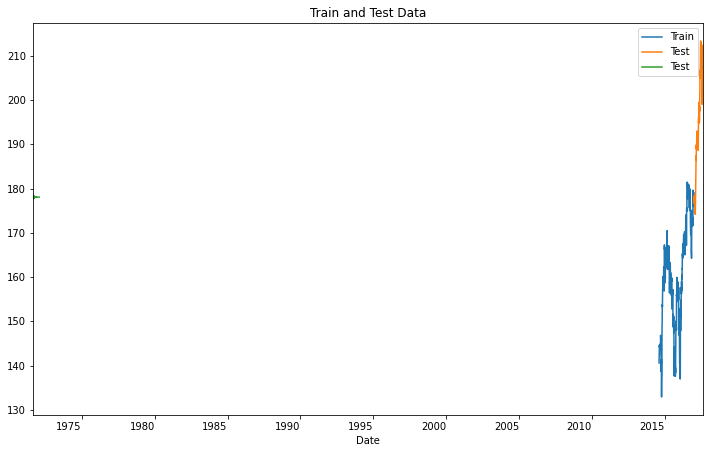

In [ ]:
df_train['Close'].plot(legend = True, label ='Train').autoscale(axis = 'x', tight = True)
df_test['Close'].plot(legend = True, label = 'Test', figsize = (12, 8)).autoscale(axis = 'x', tight = True)
forecast.plot(legend = True, label = 'Predicted', figsize = (12, 8))
plt.title('Train and Test Data')

### ARIMA

In [ ]:
#Final model 
fin_model= ARIMA(df['Close'], order = optimal[0][0]).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
forecast_predictions = fin_model.forecast(50)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
forecast_predictions

758   206.08
759   206.08
760   206.03
761   206.02
762   206.04
763   206.05
764   206.05
765   206.04
766   206.04
767   206.04
768   206.04
769   206.04
770   206.04
771   206.04
772   206.04
773   206.04
774   206.04
775   206.04
776   206.04
777   206.04
778   206.04
779   206.04
780   206.04
781   206.04
782   206.04
783   206.04
784   206.04
785   206.04
786   206.04
787   206.04
788   206.04
789   206.04
790   206.04
791   206.04
792   206.04
793   206.04
794   206.04
795   206.04
796   206.04
797   206.04
798   206.04
799   206.04
800   206.04
801   206.04
802   206.04
803   206.04
804   206.04
805   206.04
806   206.04
807   206.04
Name: predicted_mean, dtype: float64

In [ ]:
forecast_pred = list(forecast_predictions)

Text(0.5, 1.0, 'Stock Price Forecast')

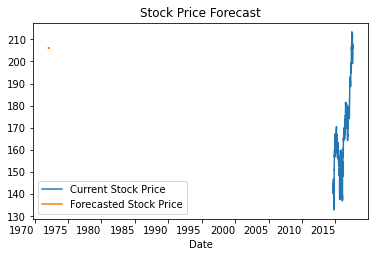

In [ ]:
df['Close'].plot(legend = True, label ='Current Stock Price')
forecast_predictions.plot(legend = True, label = 'Forecasted Stock Price')
plt.title('Stock Price Forecast')

### SARIMA

In [26]:
#Final model 
fin_model = SARIMAX(df['Close'].values, order=optimal[0][0][0], seasonal_order = optimal[0][0][1]).fit()

In [27]:
forecast_predictions = fin_model.forecast(50)

In [28]:
forecast_predictions

array([206.84181253, 207.77459902, 207.19130749, 206.77407834,
       206.24679484, 207.20567208, 207.72057251, 207.22360894,
       207.1218279 , 207.13782775, 207.60252079, 207.84107385,
       207.56011312, 207.49485095, 207.61667233, 208.46566498,
       208.03714727, 207.97145659, 207.98390266, 208.26828298,
       208.92622577, 208.61045379, 208.12683741, 208.228795  ,
       208.77133073, 209.21522352, 208.81675675, 208.95320627,
       208.6704712 , 209.32939797, 209.54670208, 209.25945667,
       209.46114242, 209.45839711, 209.54158803, 209.62047902,
       209.63008341, 209.84579084, 209.831453  , 210.35789208,
       209.90383394, 210.12332127, 210.29276999, 210.38793193,
       210.81268395, 210.56207442, 210.32376896, 210.48051548,
       210.8227176 , 211.12237512])

In [43]:
forecast_pred = list(forecast_predictions)

Text(0.5, 1.0, 'Stock Price Forecast')

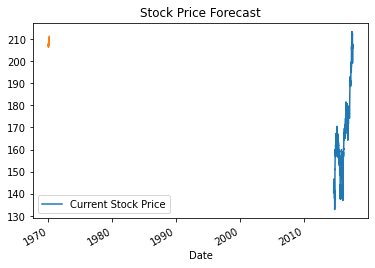

In [46]:
df['Close'].plot(legend = True, label ='Current Stock Price')
plt.plot(forecast_pred)
#forecast_pred.plot(legend = True, label = 'Forecasted Stock Price')
plt.title('Stock Price Forecast')

### Auto Arima

In [49]:
#auto_arima ram 부족 
auto_arima_model = auto_arima(df_train['Close'], start_p = 1, start_q =1,
                              max_p =3, max_q =3, seasonal = False,
                              d =1,
                              trace = True, #stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2322.126, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2317.137, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2315.980, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2316.667, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2316.335, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2317.798, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2317.386, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2317.449, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2317.086, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2318.076, Time=1.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2312.334, Time=2.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2319.408, Time=1.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2316.282, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2317.516, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2319.512, Time=0.65 sec

Best mode

In [50]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  606
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1150.167
Date:                Mon, 27 Mar 2023   AIC                           2312.334
Time:                        16:26:21   BIC                           2338.766
Sample:                             0   HQIC                          2322.620
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0911      0.100      0.914      0.361      -0.104       0.287
ar.L1          0.4323      0.035     12.291      0.000       0.363       0.501
ar.L2         -0.9045      0.033    -27.549      0.000      -0.969      -0.840
ma.L1         -0.4712      0.020    -23.231      0.000      -0.511      -0.431
ma.L2          0.9772      0.022     45.209      0.000       0.935       1.020
sigma2         2.6183      0.095     27.469      0.000       2.431       2.805
===================================================================================
Ljung-Box (L1) (Q):                   3.64   Jarque-Bera (JB):               291.76
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
prediction = auto_arima_model.predict(len(df_test['Close']), return_conf_int = True) #return_conf_int:
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(df_test.index)
predict_index[0]

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Timestamp('2017-01-05 00:00:00')

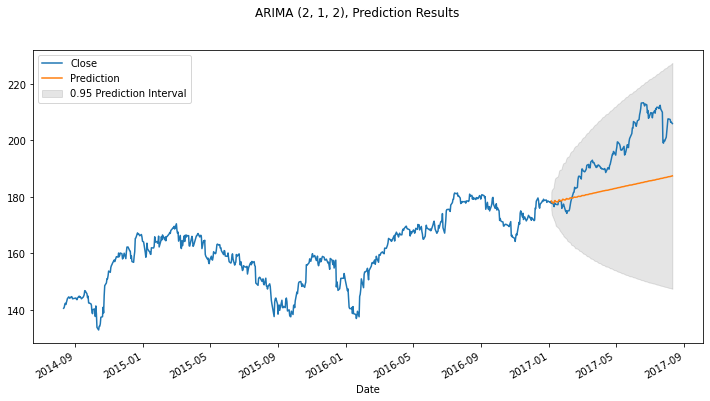

In [53]:
fig, ax = plt.subplots(figsize = (12,6))
df.Close.plot(ax = ax);
#ax.vline
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results')
plt.show()